In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai import * 
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *

import pandas as pd
import numpy as np
import os

fastai.version.__version__

'1.0.39'

In [3]:
# make sure CUDA is available and enabled
print('CUDA enabled:',torch.cuda.is_available()) 
print('CUDNN enabled:', torch.backends.cudnn.enabled)

CUDA enabled: True
CUDNN enabled: True


In [4]:
def recreate_directory(directory):
    !rm -R {directory} 2>nul
    !mkdir {directory}

# Dataset preprocessing

In [5]:
current_dir = os.getcwd()
input_path =f'{current_dir}/data'
train_dir = f"{input_path}/train"
train_labels = f"{input_path}/train.csv"
test_dir = f"{input_path}/test"
model_dir = f'{current_dir}/models'

## Train model

In [6]:
SZ = 224
BS = 64
NUM_WORKERS = 12
SEED=0
arch = models.resnet50

In [7]:
df = pd.read_csv(train_labels)
# df = df.sample(frac=0.25)
# df = df.reset_index()

print(df.shape)
print(df.head())

(6340, 3)
   index          Image         Id
0  22667  e4451a224.jpg  new_whale
1   5574  38df4000e.jpg  w_b3cc7b3
2   8019  5108219f9.jpg  w_68fc65d
3  21341  d6cf5d3ec.jpg  w_591a2c5
4   6435  41b3dc3df.jpg  w_2ed0acc


In [11]:
grouped_df = df.groupby('Id')
grouped_counted = grouped_df.count().sort_values(by=['Image'], ascending=False)
grouped_counted = grouped_counted[(grouped_counted['Image']>=2) ]
print(len(grouped_counted))
print(grouped_counted.sum().Image, 'of', len(df))
print(grouped_counted.head())

748
2790 of 4303
           index  Image
Id                     
new_whale    400    400
w_9c506f6     20     20
w_9b5109b     17     17
w_88e4537     16     16
w_2b069ba     16     16


In [12]:
valid_pct = 0.5

valid_filenames = pd.DataFrame(columns=df.columns)

for name, group in enumerate(grouped_df):
    sub_df = group[1]
    sample = sub_df.sample(frac=valid_pct)
    valid_filenames = valid_filenames.append(sample, ignore_index=True)

In [13]:
valid_filenames.drop(labels=['index'], axis=1, inplace=True, errors='ignore')

print(valid_filenames.shape)
print(valid_filenames.head())

(1459, 2)
           Image         Id
0  d9db65144.jpg  new_whale
1  b0a6afea6.jpg  new_whale
2  fe2069bdc.jpg  new_whale
3  4085e5aeb.jpg  new_whale
4  5f5493d11.jpg  new_whale


In [14]:
fn2label = {row[1].Image: row[1].Id for row in df.iterrows()}
path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)

In [15]:
valid_files = ItemList.from_df(df=valid_filenames, path=train_dir, cols=['Image'])

In [16]:
test_files = ImageItemList.from_folder(test_dir)

In [18]:
#data.show_batch(rows=3, fig_size=(SZ, SZ))

# Learning rate

In [19]:
# data_lr = (
#     ImageItemList
#         .from_df(df, train_dir, cols=['Image'])
# #         .no_split()
#         .split_by_files(valid_files)
#         .label_from_func(lambda path: fn2label[path2fn(path)])
#         .add_test(test_files)
#         .transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH)
#         .databunch(bs=BS, num_workers=NUM_WORKERS, path=input_path)
#         .normalize(imagenet_stats)
# )

In [20]:
# learn = create_cnn(data_lr, arch, metrics=accuracy, model_dir=model_dir)

In [21]:
# learn.lr_find()

In [22]:
# learn.recorder.plot()

# Precompute

In [29]:
tfms = get_transforms(max_zoom = 1.25)

In [23]:
data = (
    ImageItemList
        .from_df(df, train_dir, cols=['Image'])
        .no_split()
#         .split_by_files(valid_files)
        .label_from_func(lambda path: fn2label[path2fn(path)])
        .add_test(test_files)
        .transform(tfms, size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path=input_path)
        .normalize(imagenet_stats)
)

In [24]:
learn = create_cnn(data, arch, metrics=accuracy, model_dir=model_dir, callback_fns=ShowGraph)

epoch,train_loss,valid_loss,accuracy
1,8.037096,7.446226,0.077450
2,7.627992,6.999950,0.060315
3,7.177910,6.318832,0.129541
4,6.205472,5.884904,0.172721
5,4.949881,5.836440,0.167923


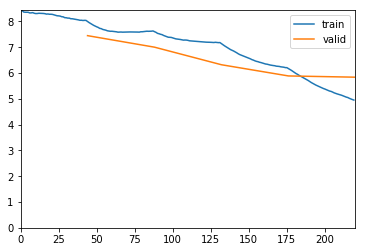

In [25]:
learn.fit_one_cycle(5, wd=1e-4, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy
1,4.113011,5.873192,0.160384
2,4.090412,5.819364,0.172036
3,3.623632,5.740576,0.178204


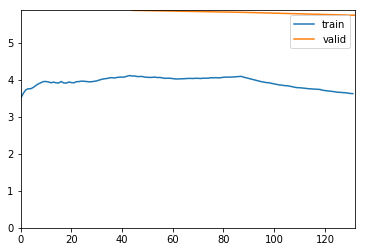

In [26]:
learn.unfreeze()
lr_rate = 1e-3
learn.fit_one_cycle(3, wd=1e-4, max_lr=[lr_rate/100, lr_rate/10, lr_rate])

# Prediction & Summition - TODO

In [27]:
log_preds,y = learn.TTA(ds_type=DatasetType.Test)

KeyboardInterrupt: 

In [ ]:
def top_preds(preds, classes):
    top = np.argsort(preds.numpy())[:, ::-1][:, :5]
    labels = []
    for i in range(top.shape[0]):
        labels.append(' '.join([classes[idx] for idx in top[i]]))
    return labels

def create_submission(preds, data):
    classes = data.classes
    sub_df = pd.DataFrame({'Image': [path.name for path in data.test_ds.x.items]})
    sub_df['Id'] = top_preds(preds, classes)
    return sub_df

In [ ]:
submittion_df = create_submission(log_preds, learn.data)

In [ ]:
submittion_file = 'submission-4-v2.csv'
submittion_df.to_csv(submittion_file, index=False)

In [ ]:
print(submittion_df.head())
print(submittion_df.shape)

In [ ]:
!kaggle competitions submit -c humpback-whale-identification -f {submittion_file} -m "learning with restarts -v2"